# Image Captioning이란?


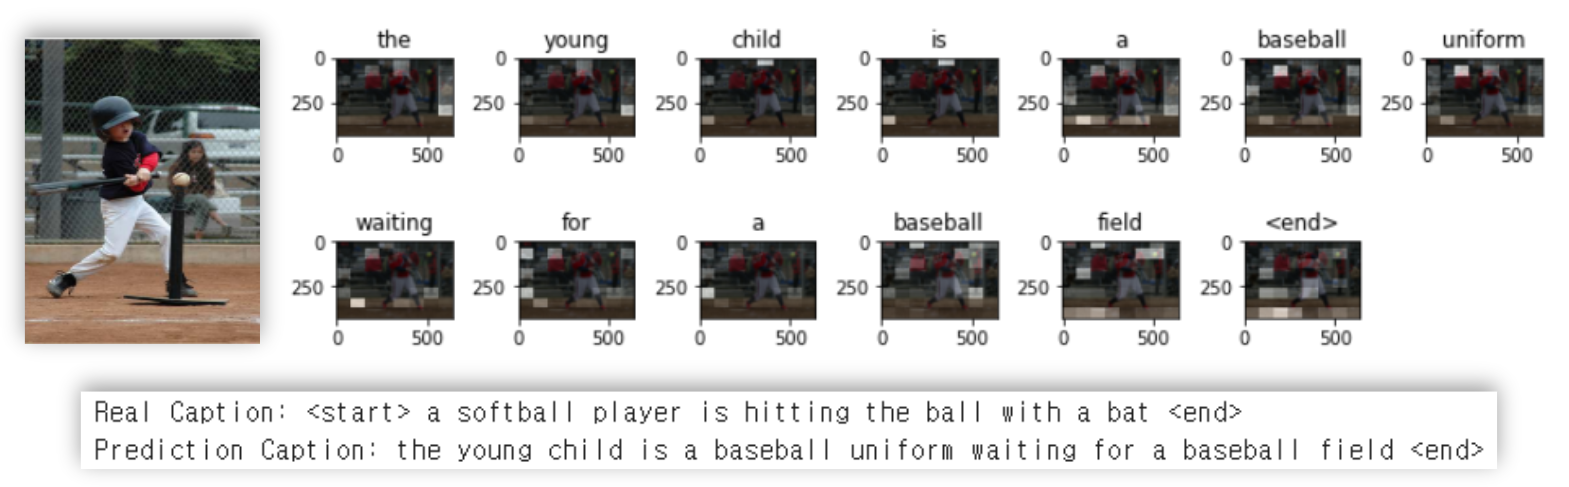

이미지 캡셔닝은 이미지가 지닌 정보를 설명해주는 한 문장을 설명하는 기술입니다.이미지 캡셔닝은 영상, 이미지를 처리하는 컴퓨터 비전, 그리고 자연어 처리라는 인공지능의 큰 축인 두 분야를 연결해주는 중요한 의의를 갖는 연구입니다. 기존의 주어진 연구들은 주로 이미지를 입력받아 영어 문장을 생성해냈다면, 저희는 이를 한국어로 문장을 생성하고자 합니다

이 모델은  [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044) 논문을 기반으로 합니다.

이 노트북 파일은 End-To-End 파일입니다. [MS COCO 2014 Dataset](https://cocodataset.org/#download)을 프로그램에서 자체적으로 다운로드하고, [AI HUB에서 제공한 한국어 Annotation File을 (편집 과정을 일부 거쳤음)](https://aihub.or.kr/keti_data_board/visual_intelligence_)을 이용자가 직접 업로드하면, Resnet-101을 이용해 이미지를 전처리 및 캐시 처리한 후, 추출해낸 Feature 값을 LSTM에 입력해 모델을 훈련합니다. 훈련된 모델을 활용해 새로운 이미지에 대한 캡션을 생성하고, 이를 BLEU 기준을 통해 평가하는 것까지가 하나의 프로그램이 될 것입니다. 




---
# Image-captioning-pepper_prototype

In [9]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import pandas as pd
import os
import time
import json
from PIL import Image
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

plt.rc('font', family = 'NanumBarunGothic')

In [10]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())

2.8.0
True
True
/device:GPU:0


## Pepper Dataset

In [11]:
image_folder ='C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/'
PATH = image_folder

## Green pumkin

In [ ]:
image_folder ='C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/'
PATH = image_folder

In [12]:
annotations = pd.read_csv("C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/pepper_disease_normal.csv", encoding='cp949')
annotations.head()

Unnamed: 0                                        images  \
0           0  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
1           1  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
2           2  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
3           3  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
4           4  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   

                                      captions  
0  고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다  
1      고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다  
2                 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다  
3           고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다  
4       고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다

### Group all captions together having the same image ID.
* `<start> <end>` 붙여주기
* `image_path` 정의
* `image_path_to_caption` 정의

In [13]:
annotations['captions'] = annotations['captions'].apply(lambda x: '<start> ' + x + ' <end>')
annotations.head()

Unnamed: 0                                        images  \
0           0  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
1           1  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
2           2  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
3           3  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   
4           4  V006_79_1_01_01_01_13_1_0149z_20201007_1.JPG   

                                            captions  
0  <start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 ...  
1  <start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니...  
2         <start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>  
3   <start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>  
4  <start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다...

In [14]:
print(len(annotations))

120815


* defualtdictionary 형식의 image_path_to_caption 에 (key)1개 이미지 경로 당, (values)5개 caption을 한 리스트로 생성  

In [15]:
image_path_to_caption = collections.defaultdict(list)
for i in range(len(annotations)):
    image_path = PATH + annotations.images[i]
#     print(image_path, '\n')
    image_path_to_caption[image_path].append(annotations.captions[i])
#     print(image_path_to_caption)
print(image_path)
print(image_path_to_caption[image_path])

C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/V006_79_0_00_01_03_13_0_c44_20201026_0001_S01_1.jpg
['<start> 고추에 이상 징후가 발견되지 않아 정상 고춧잎으로 사료됩니다 <end>', '<start> 특별한 이상 징후가 없는 고춧잎으로 판단됩니다 <end>', '<start> 병에 대한 증상이 나타나지 않는 정상 고춧잎으로 판단됩니다 <end>', '<start> 병의 증세가 나타나지 않는 정상적인 고춧잎으로 판단됩니다 <end>', '<start> 고춧잎에 특별한 병의 증세가 나타나지 않아 정상으로 판단됩니다 <end>']


* train_image_paths 에 image 들의 이름(key)들만을 리스트로 정의 
    * shuffle 로 섞어주기
* *용량 제한*을 두어 30,000개의 캡션(6,000개의 이미지)만 사용 가능
    * ex) `train_image_paths = image_paths[:6000]`

In [16]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths #[:6000]
print(len(train_image_paths))
# print(train_image_paths)

24163


In [17]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
#     print(image_path_to_caption[image_path],'\n')
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
#     print(len(caption_list))
    img_name_vector.extend([image_path] * len(caption_list))
print(caption_list)
print()
print(img_name_vector[:6])

['<start> 고추에 움푹 들어간 원형 반점이 나타나는 것으로 보아 고추탄저병으로 의심됩니다 <end>', '<start> 고추에 원형 반점이 움푹 들어나는 양상을 보여 고추탄저병으로 의심됩니다 <end>', '<start> 고추에 원형 반점이 나타나 고추탄저병으로 의심됩니다 <end>', '<start> 고추에 원형 반점이 생긴 것으로 보아 고추탄저병으로 의심됩니다 <end>', '<start> 고추에 원형 반점이 움푹 들어간 것으로 보아 고추탄저병으로 의심됩니다 <end>']

['C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/V006_79_0_00_01_01_13_0_c32_20201029_0002_S01_1.jpg', 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/V006_79_0_00_01_01_13_0_c32_20201029_0002_S01_1.jpg', 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/V006_79_0_00_01_01_13_0_c32_20201029_0002_S01_1.jpg', 'C:/Users/DI Lee/Desktop/Korean_Based_Image_Captioning_Model-main/pepper_prototype/pepper_dataset_prototype/train/pepper_images/V006_79_0_00_01_01_13_0_c32_20201029_0002_S01_1.jpg

## ResNet101 사용하여 이미지 전처리하기

다음으로, (Imagenet에 대해 사전 훈련된) ResNet101을 사용하여 이미지를 분류하고 마지막 Convolutional Layer에서 특징을 추출해냅니다.

- 이미지를 299px x 299px로 resize합니다.
- [ResNet101 설명](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101)

In [18]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

## ResNet101 초기화 및 사전 훈련된 Imagenet 가중치 로드하기

이제 Output Layer가 InceptionV3의 마지막 Convolutional Layer인 tf.keras 모델을 만듭니다.

- 네트워크를 통해 각 이미지를 전달하고 결과 벡터를 사전 (image_name --&gt; feature_vector)에 저장합니다.
- 모든 이미지가 네트워크를 통해 전달된 후, 사전을 디스크에 저장합니다.

In [19]:
image_model = tf.keras.applications.ResNet101(include_top=False,
                                                weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [20]:
print(image_features_extract_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

## ResNet101에서 추출된 특성 캐시하기

ResNet101로 각 이미지를 사전 처리하고 출력을 디스크에 캐시합니다. 현재 코드보다 정교한 캐싱 전략(ex. 임의 액세스 디스크 I/O를 줄이기 위해 이미지 분할 등)으로 성능을 향상할 수 있습니다.


In [21]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 1511/1511 [05:29<00:00,  4.58it/s]


## 캡션 전처리 및 토큰화하기

- 캡션을 토큰화합니다. 그리고 최대 단어의 크기를 상위 10,000개 단어로 제한합니다. 
그 단어 이외의 단어들은 토큰 "UNK"(알 수 없음)로 대체됩니다.
- 그 후, 단어 대 인덱스 및 인덱스 대 단어 매핑을 만듭니다.
- 마지막으로, 모든 시퀀스를 가장 긴 시퀀스와 같은 길이로 채웁니다.

In [22]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [23]:
print(len(train_captions))

120815


In [24]:
# Choose the top 10,000 words from the vocabulary
top_k = 10000
#oov = outofvocab
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
# print(train_captions)

In [25]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '사료됩니다': 20, '포자덩어리와': 21, '움푹': 22, '병무늬가': 23, '들어간': 24, '반점이': 25, '잎에': 26, '포자와': 27, '포자덩어리가': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '않아': 33, '특별한': 34, '판단됩니다': 35, '서릿발': 36, '모양의': 37, '이슬과': 38, '원형반점이': 39, '증상이': 40, '곰팡이가': 41, '것을': 42, '반점무늬가': 43, '바른': 44, '것과': 45, '발견되지': 46, '생긴': 47, '나타나며': 48, '넓게': 49, '고추가': 50, '이상이': 51, '없는': 52, '원형반점과': 53, '밀가루를': 54, '얇은': 55, '고춧잎으로': 56, '이상': 57, '징후가': 58, '정상': 59, '나타나지': 60, '고추로': 61, '비틀어지고': 62, '보여': 63, '말라비틀어진': 64, '고추탄저병이': 65, '곰팡이와': 66, '않는': 67, '병의': 68, '증세가': 69, '고춧잎에': 70, '병무늬와': 71, '밀가루': 72, '반점무늬와': 73, '보이고': 74, '생겼고': 75, '없다고': 76, '보이지': 77, '아무': 78, '병에': 79, '대한': 80, '정상적인': 81, '정상으로': 82, '보이는': 83, '발견되므로': 84, '고춧잎에서': 85, '고추에서는': 86, '곳으로': 87, '고추에서'

In [26]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [27]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '의심됩니다', 5: '보아', 6: '것으로', 7: '고추에', 8: '고추탄저병으로', 9: '고추흰가루병으로', 10: '담황색', 11: '원형', 12: '말라', 13: '비틀어진', 14: '나타나고', 15: '발견되어', 16: '황갈색의', 17: '황갈색', 18: '같은', 19: '나타나는', 20: '사료됩니다', 21: '포자덩어리와', 22: '움푹', 23: '병무늬가', 24: '들어간', 25: '반점이', 26: '잎에', 27: '포자와', 28: '포자덩어리가', 29: '포자가', 30: '반점과', 31: '연한', 32: '흰색', 33: '않아', 34: '특별한', 35: '판단됩니다', 36: '서릿발', 37: '모양의', 38: '이슬과', 39: '원형반점이', 40: '증상이', 41: '곰팡이가', 42: '것을', 43: '반점무늬가', 44: '바른', 45: '것과', 46: '발견되지', 47: '생긴', 48: '나타나며', 49: '넓게', 50: '고추가', 51: '이상이', 52: '없는', 53: '원형반점과', 54: '밀가루를', 55: '얇은', 56: '고춧잎으로', 57: '이상', 58: '징후가', 59: '정상', 60: '나타나지', 61: '고추로', 62: '비틀어지고', 63: '보여', 64: '말라비틀어진', 65: '고추탄저병이', 66: '곰팡이와', 67: '않는', 68: '병의', 69: '증세가', 70: '고춧잎에', 71: '병무늬와', 72: '밀가루', 73: '반점무늬와', 74: '보이고', 75: '생겼고', 76: '없다고', 77: '보이지', 78: '아무', 79: '병에', 80: '대한', 81: '정상적인', 82: '정상으로', 83: '보이는', 84: '발견되므로', 85: '고춧잎에서', 86: '고추에서는', 87: '곳으로', 88: '고

In [28]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [29]:
print(train_seqs[:5])

[[2, 7, 57, 58, 46, 33, 59, 61, 20, 3], [2, 34, 57, 58, 52, 61, 35, 3], [2, 79, 80, 40, 60, 67, 59, 61, 35, 3], [2, 68, 69, 60, 67, 81, 61, 35, 3], [2, 7, 34, 68, 69, 60, 33, 82, 35, 3]]


In [30]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector[:10])

[[ 2  7 57 58 46 33 59 61 20  3  0  0  0  0  0  0]
 [ 2 34 57 58 52 61 35  3  0  0  0  0  0  0  0  0]
 [ 2 79 80 40 60 67 59 61 35  3  0  0  0  0  0  0]
 [ 2 68 69 60 67 81 61 35  3  0  0  0  0  0  0  0]
 [ 2  7 34 68 69 60 33 82 35  3  0  0  0  0  0  0]
 [ 2 22 24 11 30 16 28 14 50 12 13  6  5  8  4  3]
 [ 2  7 11 30 17 28 14 12 13 42  5  8  4  3  0  0]
 [ 2 17 21 39  7 75 12 13  6  5  8  4  3  0  0  0]
 [ 2 50 12 62 17 21 39 47  6  5  8  4  3  0  0  0]
 [ 2 50 12 62 53 17 28 15  8 20  3  0  0  0  0  0]]


In [31]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## 데이터를 훈련(Train) 및 평가(Validation) 데이터셋로 분할하기




In [32]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80:20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

## 훈련을 위한 tf.data 데이터세트 생성하기


이미지와 캡션이 준비되었습니다. 다음으로 모델 훈련에 사용할 `tf.data` 데이터세트를 만듭니다.

In [33]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from ResNet101 is (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [34]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 모델

모델은 Encoder로 CNN을 Decoder로 RNN을 활용합니다. 
- CNN에서는 이미지의 Feature들을 추출해낸 후, 
- 추출한 Feature들을 RNN을 통해서 단어 토큰으로 출력하는 구조로 이루어집니다. 

In [36]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 100, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 100, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 100, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 100, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [37]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 100, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [38]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [39]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [40]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 체크포인트

In [41]:
checkpoint_path = "./checkpoints_pepper_prototype/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## 훈련하기

- 각 `.npy` 파일에 저장된 특성을 추출한 다음, 해당 특성을 endcoder를 통해 전달합니다.
- encoder의 출력값, decoder의 hidden state(0으로 초기화됨) 및 입력값(start token)이 decoder로 전달됩니다.
- decoder는 예측값 및 decoder hidden state를 반환합니다.
- 그 후 decoder hidden state가 모델로 다시 전달되고, 예측값은 손실을 계산하는 데 사용됩니다. 
- teacher forcing를 사용하여 decoder에 대한 다음 입력을 결정합니다. teacher forcing은 출력값이, 다음 입력값으로 decoder에 전달되는 기법입니다.
- 마지막으로 Gradient를 계산하고 이를 Optimizer에 적용하여 Back-propagation합니다.


In [43]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [44]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '의심됩니다': 4, '보아': 5, '것으로': 6, '고추에': 7, '고추탄저병으로': 8, '고추흰가루병으로': 9, '담황색': 10, '원형': 11, '말라': 12, '비틀어진': 13, '나타나고': 14, '발견되어': 15, '황갈색의': 16, '황갈색': 17, '같은': 18, '나타나는': 19, '사료됩니다': 20, '포자덩어리와': 21, '움푹': 22, '병무늬가': 23, '들어간': 24, '반점이': 25, '잎에': 26, '포자와': 27, '포자덩어리가': 28, '포자가': 29, '반점과': 30, '연한': 31, '흰색': 32, '않아': 33, '특별한': 34, '판단됩니다': 35, '서릿발': 36, '모양의': 37, '이슬과': 38, '원형반점이': 39, '증상이': 40, '곰팡이가': 41, '것을': 42, '반점무늬가': 43, '바른': 44, '것과': 45, '발견되지': 46, '생긴': 47, '나타나며': 48, '넓게': 49, '고추가': 50, '이상이': 51, '없는': 52, '원형반점과': 53, '밀가루를': 54, '얇은': 55, '고춧잎으로': 56, '이상': 57, '징후가': 58, '정상': 59, '나타나지': 60, '고추로': 61, '비틀어지고': 62, '보여': 63, '말라비틀어진': 64, '고추탄저병이': 65, '곰팡이와': 66, '않는': 67, '병의': 68, '증세가': 69, '고춧잎에': 70, '병무늬와': 71, '밀가루': 72, '반점무늬와': 73, '보이고': 74, '생겼고': 75, '없다고': 76, '보이지': 77, '아무': 78, '병에': 79, '대한': 80, '정상적인': 81, '정상으로': 82, '보이는': 83, '발견되므로': 84, '고춧잎에서': 85, '고추에서는': 86, '곳으로': 87, '고추에서'

In [45]:
print(tokenizer.word_index['<unk>'])

1


In [46]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
#     print(tokenizer.word_index)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

- Epoch는 다음 학습을 몇 번 반복할 지를 결정합니다. 
- Default 값으로는 20번으로 지정되어있습니다.
- 이용자가 원하는 만큼 지정해서 성능을 향상시킵니다.

In [47]:
from tqdm import tqdm
import time

EPOCHS = 20
start_epoch = 0

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 6.2334
Epoch 1 Batch 100 Loss 1.9917
Epoch 1 Batch 200 Loss 0.4797
Epoch 1 Batch 300 Loss 0.3915
Epoch 1 Batch 400 Loss 0.3700
Epoch 1 Batch 500 Loss 0.3245
Epoch 1 Batch 600 Loss 0.2815
Epoch 1 Batch 700 Loss 0.2720
Epoch 1 Batch 800 Loss 0.2256
Epoch 1 Batch 900 Loss 0.2370
Epoch 1 Batch 1000 Loss 0.2152
Epoch 1 Batch 1100 Loss 0.2270
Epoch 1 Batch 1200 Loss 0.2238
Epoch 1 Batch 1300 Loss 0.2135
Epoch 1 Batch 1400 Loss 0.2059
Epoch 1 Batch 1500 Loss 0.1859


  5%|████                                                                              | 1/20 [01:56<37:02, 116.96s/it]

Epoch 1 Loss 0.474326
Time taken for 1 epoch 116.96 sec

Epoch 2 Batch 0 Loss 0.2254
Epoch 2 Batch 100 Loss 0.1831
Epoch 2 Batch 200 Loss 0.1896
Epoch 2 Batch 300 Loss 0.1909
Epoch 2 Batch 400 Loss 0.1964
Epoch 2 Batch 500 Loss 0.1834
Epoch 2 Batch 600 Loss 0.1997
Epoch 2 Batch 700 Loss 0.1690
Epoch 2 Batch 800 Loss 0.1831
Epoch 2 Batch 900 Loss 0.1774
Epoch 2 Batch 1000 Loss 0.1563
Epoch 2 Batch 1100 Loss 0.1701
Epoch 2 Batch 1200 Loss 0.1931
Epoch 2 Batch 1300 Loss 0.1752
Epoch 2 Batch 1400 Loss 0.1639
Epoch 2 Batch 1500 Loss 0.1704


 10%|████████▏                                                                         | 2/20 [03:40<32:39, 108.88s/it]

Epoch 2 Loss 0.175835
Time taken for 1 epoch 103.23 sec

Epoch 3 Batch 0 Loss 0.1841
Epoch 3 Batch 100 Loss 0.1551
Epoch 3 Batch 200 Loss 0.1500
Epoch 3 Batch 300 Loss 0.1464
Epoch 3 Batch 400 Loss 0.1575
Epoch 3 Batch 500 Loss 0.1426
Epoch 3 Batch 600 Loss 0.1435
Epoch 3 Batch 700 Loss 0.1830
Epoch 3 Batch 800 Loss 0.1475
Epoch 3 Batch 900 Loss 0.1560
Epoch 3 Batch 1000 Loss 0.1496
Epoch 3 Batch 1100 Loss 0.1462
Epoch 3 Batch 1200 Loss 0.1275
Epoch 3 Batch 1300 Loss 0.1503
Epoch 3 Batch 1400 Loss 0.1461
Epoch 3 Batch 1500 Loss 0.1384


 15%|████████████▎                                                                     | 3/20 [05:22<30:01, 105.96s/it]

Epoch 3 Loss 0.148432
Time taken for 1 epoch 102.47 sec

Epoch 4 Batch 0 Loss 0.1632
Epoch 4 Batch 100 Loss 0.1669
Epoch 4 Batch 200 Loss 0.1480
Epoch 4 Batch 300 Loss 0.1327
Epoch 4 Batch 400 Loss 0.1425
Epoch 4 Batch 500 Loss 0.1312
Epoch 4 Batch 600 Loss 0.1425
Epoch 4 Batch 700 Loss 0.1377
Epoch 4 Batch 800 Loss 0.1338
Epoch 4 Batch 900 Loss 0.1411
Epoch 4 Batch 1000 Loss 0.1556
Epoch 4 Batch 1100 Loss 0.1294
Epoch 4 Batch 1200 Loss 0.1338
Epoch 4 Batch 1300 Loss 0.1261
Epoch 4 Batch 1400 Loss 0.1228
Epoch 4 Batch 1500 Loss 0.1300


 20%|████████████████▍                                                                 | 4/20 [07:05<27:55, 104.69s/it]

Epoch 4 Loss 0.136141
Time taken for 1 epoch 102.75 sec

Epoch 5 Batch 0 Loss 0.1388
Epoch 5 Batch 100 Loss 0.1330
Epoch 5 Batch 200 Loss 0.1324
Epoch 5 Batch 300 Loss 0.1281
Epoch 5 Batch 400 Loss 0.1335
Epoch 5 Batch 500 Loss 0.1292
Epoch 5 Batch 600 Loss 0.1280
Epoch 5 Batch 700 Loss 0.1285
Epoch 5 Batch 800 Loss 0.1295
Epoch 5 Batch 900 Loss 0.1363
Epoch 5 Batch 1000 Loss 0.1250
Epoch 5 Batch 1100 Loss 0.1263
Epoch 5 Batch 1200 Loss 0.1221
Epoch 5 Batch 1300 Loss 0.1479
Epoch 5 Batch 1400 Loss 0.1490
Epoch 5 Batch 1500 Loss 0.1348


 25%|████████████████████▌                                                             | 5/20 [08:43<25:35, 102.35s/it]

Epoch 5 Loss 0.130226
Time taken for 1 epoch 98.18 sec

Epoch 6 Batch 0 Loss 0.1190
Epoch 6 Batch 100 Loss 0.1272
Epoch 6 Batch 200 Loss 0.1304
Epoch 6 Batch 300 Loss 0.1253
Epoch 6 Batch 400 Loss 0.1330
Epoch 6 Batch 500 Loss 0.1221
Epoch 6 Batch 600 Loss 0.1237
Epoch 6 Batch 700 Loss 0.1199
Epoch 6 Batch 800 Loss 0.1263
Epoch 6 Batch 900 Loss 0.1328
Epoch 6 Batch 1000 Loss 0.1183
Epoch 6 Batch 1100 Loss 0.1179
Epoch 6 Batch 1200 Loss 0.1393
Epoch 6 Batch 1300 Loss 0.1306
Epoch 6 Batch 1400 Loss 0.1223
Epoch 6 Batch 1500 Loss 0.1236


 30%|████████████████████████▌                                                         | 6/20 [10:23<23:41, 101.56s/it]

Epoch 6 Loss 0.126326
Time taken for 1 epoch 100.04 sec

Epoch 7 Batch 0 Loss 0.1545
Epoch 7 Batch 100 Loss 0.1232
Epoch 7 Batch 200 Loss 0.1276
Epoch 7 Batch 300 Loss 0.1256
Epoch 7 Batch 400 Loss 0.1236
Epoch 7 Batch 500 Loss 0.1144
Epoch 7 Batch 600 Loss 0.1188
Epoch 7 Batch 700 Loss 0.1410
Epoch 7 Batch 800 Loss 0.1193
Epoch 7 Batch 900 Loss 0.1191
Epoch 7 Batch 1000 Loss 0.1229
Epoch 7 Batch 1100 Loss 0.1249
Epoch 7 Batch 1200 Loss 0.1356
Epoch 7 Batch 1300 Loss 0.1275
Epoch 7 Batch 1400 Loss 0.1344
Epoch 7 Batch 1500 Loss 0.1188


 35%|████████████████████████████▋                                                     | 7/20 [12:05<22:02, 101.73s/it]

Epoch 7 Loss 0.123807
Time taken for 1 epoch 102.07 sec

Epoch 8 Batch 0 Loss 0.1228
Epoch 8 Batch 100 Loss 0.1220
Epoch 8 Batch 200 Loss 0.1343
Epoch 8 Batch 300 Loss 0.1132
Epoch 8 Batch 400 Loss 0.1119
Epoch 8 Batch 500 Loss 0.1234
Epoch 8 Batch 600 Loss 0.1185
Epoch 8 Batch 700 Loss 0.1278
Epoch 8 Batch 800 Loss 0.1142
Epoch 8 Batch 900 Loss 0.1179
Epoch 8 Batch 1000 Loss 0.1156
Epoch 8 Batch 1100 Loss 0.1222
Epoch 8 Batch 1200 Loss 0.1199
Epoch 8 Batch 1300 Loss 0.1250
Epoch 8 Batch 1400 Loss 0.1115
Epoch 8 Batch 1500 Loss 0.1101


 40%|████████████████████████████████▊                                                 | 8/20 [13:47<20:22, 101.85s/it]

Epoch 8 Loss 0.121926
Time taken for 1 epoch 102.11 sec

Epoch 9 Batch 0 Loss 0.1301
Epoch 9 Batch 100 Loss 0.1158
Epoch 9 Batch 200 Loss 0.1246
Epoch 9 Batch 300 Loss 0.1158
Epoch 9 Batch 400 Loss 0.1100
Epoch 9 Batch 500 Loss 0.1131
Epoch 9 Batch 600 Loss 0.1129
Epoch 9 Batch 700 Loss 0.1181
Epoch 9 Batch 800 Loss 0.1190
Epoch 9 Batch 900 Loss 0.1161
Epoch 9 Batch 1000 Loss 0.1105
Epoch 9 Batch 1100 Loss 0.1139
Epoch 9 Batch 1200 Loss 0.1226
Epoch 9 Batch 1300 Loss 0.1178
Epoch 9 Batch 1400 Loss 0.1185
Epoch 9 Batch 1500 Loss 0.1238


 45%|████████████████████████████████████▉                                             | 9/20 [15:29<18:40, 101.89s/it]

Epoch 9 Loss 0.118096
Time taken for 1 epoch 101.97 sec

Epoch 10 Batch 0 Loss 0.1376
Epoch 10 Batch 100 Loss 0.1149
Epoch 10 Batch 200 Loss 0.1364
Epoch 10 Batch 300 Loss 0.1127
Epoch 10 Batch 400 Loss 0.1109
Epoch 10 Batch 500 Loss 0.1137
Epoch 10 Batch 600 Loss 0.1158
Epoch 10 Batch 700 Loss 0.1140
Epoch 10 Batch 800 Loss 0.1160
Epoch 10 Batch 900 Loss 0.1278
Epoch 10 Batch 1000 Loss 0.1193
Epoch 10 Batch 1100 Loss 0.1146
Epoch 10 Batch 1200 Loss 0.1197
Epoch 10 Batch 1300 Loss 0.1140
Epoch 10 Batch 1400 Loss 0.1122
Epoch 10 Batch 1500 Loss 0.1074


 50%|████████████████████████████████████████▌                                        | 10/20 [17:12<17:01, 102.11s/it]

Epoch 10 Loss 0.116112
Time taken for 1 epoch 102.59 sec

Epoch 11 Batch 0 Loss 0.1075
Epoch 11 Batch 100 Loss 0.1291
Epoch 11 Batch 200 Loss 0.1125
Epoch 11 Batch 300 Loss 0.1162
Epoch 11 Batch 400 Loss 0.1149
Epoch 11 Batch 500 Loss 0.1267
Epoch 11 Batch 600 Loss 0.1112
Epoch 11 Batch 700 Loss 0.1213
Epoch 11 Batch 800 Loss 0.1171
Epoch 11 Batch 900 Loss 0.1195
Epoch 11 Batch 1000 Loss 0.1091
Epoch 11 Batch 1100 Loss 0.1106
Epoch 11 Batch 1200 Loss 0.1127
Epoch 11 Batch 1300 Loss 0.1087
Epoch 11 Batch 1400 Loss 0.1171
Epoch 11 Batch 1500 Loss 0.1320


 55%|████████████████████████████████████████████▌                                    | 11/20 [18:55<15:22, 102.51s/it]

Epoch 11 Loss 0.114430
Time taken for 1 epoch 103.44 sec

Epoch 12 Batch 0 Loss 0.2087
Epoch 12 Batch 100 Loss 0.1143
Epoch 12 Batch 200 Loss 0.1204
Epoch 12 Batch 300 Loss 0.1109
Epoch 12 Batch 400 Loss 0.1110
Epoch 12 Batch 500 Loss 0.1129
Epoch 12 Batch 600 Loss 0.1181
Epoch 12 Batch 700 Loss 0.1113
Epoch 12 Batch 800 Loss 0.1759
Epoch 12 Batch 900 Loss 0.1075
Epoch 12 Batch 1000 Loss 0.1153
Epoch 12 Batch 1100 Loss 0.1180
Epoch 12 Batch 1200 Loss 0.1171
Epoch 12 Batch 1300 Loss 0.1121
Epoch 12 Batch 1400 Loss 0.1058
Epoch 12 Batch 1500 Loss 0.1247


 60%|████████████████████████████████████████████████▌                                | 12/20 [20:39<13:41, 102.73s/it]

Epoch 12 Loss 0.114457
Time taken for 1 epoch 103.23 sec

Epoch 13 Batch 0 Loss 0.1110
Epoch 13 Batch 100 Loss 0.1169
Epoch 13 Batch 200 Loss 0.1294
Epoch 13 Batch 300 Loss 0.1131
Epoch 13 Batch 400 Loss 0.1124
Epoch 13 Batch 500 Loss 0.1102
Epoch 13 Batch 600 Loss 0.1177
Epoch 13 Batch 700 Loss 0.1249
Epoch 13 Batch 800 Loss 0.1136
Epoch 13 Batch 900 Loss 0.1111
Epoch 13 Batch 1000 Loss 0.1119
Epoch 13 Batch 1100 Loss 0.1208
Epoch 13 Batch 1200 Loss 0.1111
Epoch 13 Batch 1300 Loss 0.1129
Epoch 13 Batch 1400 Loss 0.1089
Epoch 13 Batch 1500 Loss 0.1131


 65%|████████████████████████████████████████████████████▋                            | 13/20 [22:21<11:58, 102.59s/it]

Epoch 13 Loss 0.113829
Time taken for 1 epoch 102.25 sec

Epoch 14 Batch 0 Loss 0.1127
Epoch 14 Batch 100 Loss 0.1099
Epoch 14 Batch 200 Loss 0.1150
Epoch 14 Batch 300 Loss 0.1145
Epoch 14 Batch 400 Loss 0.1180
Epoch 14 Batch 500 Loss 0.1140
Epoch 14 Batch 600 Loss 0.1172
Epoch 14 Batch 700 Loss 0.1087
Epoch 14 Batch 800 Loss 0.1115
Epoch 14 Batch 900 Loss 0.1084
Epoch 14 Batch 1000 Loss 0.1111
Epoch 14 Batch 1100 Loss 0.1085
Epoch 14 Batch 1200 Loss 0.1176
Epoch 14 Batch 1300 Loss 0.1149
Epoch 14 Batch 1400 Loss 0.1110
Epoch 14 Batch 1500 Loss 0.1108


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [24:03<10:14, 102.40s/it]

Epoch 14 Loss 0.114242
Time taken for 1 epoch 101.95 sec

Epoch 15 Batch 0 Loss 0.1116
Epoch 15 Batch 100 Loss 0.1098
Epoch 15 Batch 200 Loss 0.1230
Epoch 15 Batch 300 Loss 0.1182
Epoch 15 Batch 400 Loss 0.1093
Epoch 15 Batch 500 Loss 0.1113
Epoch 15 Batch 600 Loss 0.1109
Epoch 15 Batch 700 Loss 0.1095
Epoch 15 Batch 800 Loss 0.1078
Epoch 15 Batch 900 Loss 0.1134
Epoch 15 Batch 1000 Loss 0.1051
Epoch 15 Batch 1100 Loss 0.1113
Epoch 15 Batch 1200 Loss 0.1128
Epoch 15 Batch 1300 Loss 0.1119
Epoch 15 Batch 1400 Loss 0.1104
Epoch 15 Batch 1500 Loss 0.1112


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [25:45<08:32, 102.41s/it]

Epoch 15 Loss 0.111601
Time taken for 1 epoch 102.44 sec

Epoch 16 Batch 0 Loss 0.1226
Epoch 16 Batch 100 Loss 0.1124
Epoch 16 Batch 200 Loss 0.1066
Epoch 16 Batch 300 Loss 0.1166
Epoch 16 Batch 400 Loss 0.1092
Epoch 16 Batch 500 Loss 0.1205
Epoch 16 Batch 600 Loss 0.1077
Epoch 16 Batch 700 Loss 0.1101
Epoch 16 Batch 800 Loss 0.1146
Epoch 16 Batch 900 Loss 0.1134
Epoch 16 Batch 1000 Loss 0.1044
Epoch 16 Batch 1100 Loss 0.1126
Epoch 16 Batch 1200 Loss 0.1246
Epoch 16 Batch 1300 Loss 0.1167
Epoch 16 Batch 1400 Loss 0.1133
Epoch 16 Batch 1500 Loss 0.1094


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [27:27<06:48, 102.19s/it]

Epoch 16 Loss 0.111831
Time taken for 1 epoch 101.69 sec

Epoch 17 Batch 0 Loss 0.1102
Epoch 17 Batch 100 Loss 0.1107
Epoch 17 Batch 200 Loss 0.1083
Epoch 17 Batch 300 Loss 0.1075
Epoch 17 Batch 400 Loss 0.1120
Epoch 17 Batch 500 Loss 0.1151
Epoch 17 Batch 600 Loss 0.1128
Epoch 17 Batch 700 Loss 0.1069
Epoch 17 Batch 800 Loss 0.1085
Epoch 17 Batch 900 Loss 0.1122
Epoch 17 Batch 1000 Loss 0.1047
Epoch 17 Batch 1100 Loss 0.1069
Epoch 17 Batch 1200 Loss 0.1078
Epoch 17 Batch 1300 Loss 0.1079
Epoch 17 Batch 1400 Loss 0.1230
Epoch 17 Batch 1500 Loss 0.1099


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [29:10<05:07, 102.36s/it]

Epoch 17 Loss 0.112039
Time taken for 1 epoch 102.74 sec

Epoch 18 Batch 0 Loss 0.1088
Epoch 18 Batch 100 Loss 0.1110
Epoch 18 Batch 200 Loss 0.1139
Epoch 18 Batch 300 Loss 0.1116
Epoch 18 Batch 400 Loss 0.1082
Epoch 18 Batch 500 Loss 0.1093
Epoch 18 Batch 600 Loss 0.1210
Epoch 18 Batch 700 Loss 0.1132
Epoch 18 Batch 800 Loss 0.1138
Epoch 18 Batch 900 Loss 0.1068
Epoch 18 Batch 1000 Loss 0.1068
Epoch 18 Batch 1100 Loss 0.1070
Epoch 18 Batch 1200 Loss 0.1097
Epoch 18 Batch 1300 Loss 0.1038
Epoch 18 Batch 1400 Loss 0.1092
Epoch 18 Batch 1500 Loss 0.1061


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [30:51<03:23, 101.97s/it]

Epoch 18 Loss 0.111374
Time taken for 1 epoch 101.07 sec

Epoch 19 Batch 0 Loss 0.1129
Epoch 19 Batch 100 Loss 0.1187
Epoch 19 Batch 200 Loss 0.1329
Epoch 19 Batch 300 Loss 0.1078
Epoch 19 Batch 400 Loss 0.1066
Epoch 19 Batch 500 Loss 0.1061
Epoch 19 Batch 600 Loss 0.1149
Epoch 19 Batch 700 Loss 0.1078
Epoch 19 Batch 800 Loss 0.1135
Epoch 19 Batch 900 Loss 0.1097
Epoch 19 Batch 1000 Loss 0.1091
Epoch 19 Batch 1100 Loss 0.1125
Epoch 19 Batch 1200 Loss 0.1063
Epoch 19 Batch 1300 Loss 0.1145
Epoch 19 Batch 1400 Loss 0.1122
Epoch 19 Batch 1500 Loss 0.1064


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [32:31<01:41, 101.57s/it]

Epoch 19 Loss 0.111240
Time taken for 1 epoch 100.62 sec

Epoch 20 Batch 0 Loss 0.1084
Epoch 20 Batch 100 Loss 0.1107
Epoch 20 Batch 200 Loss 0.1143
Epoch 20 Batch 300 Loss 0.1071
Epoch 20 Batch 400 Loss 0.1065
Epoch 20 Batch 500 Loss 0.1194
Epoch 20 Batch 600 Loss 0.1054
Epoch 20 Batch 700 Loss 0.1110
Epoch 20 Batch 800 Loss 0.1071
Epoch 20 Batch 900 Loss 0.1130
Epoch 20 Batch 1000 Loss 0.1088
Epoch 20 Batch 1100 Loss 0.1125
Epoch 20 Batch 1200 Loss 0.1182
Epoch 20 Batch 1300 Loss 0.1126
Epoch 20 Batch 1400 Loss 0.1068
Epoch 20 Batch 1500 Loss 0.1067


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [34:11<00:00, 102.57s/it]

Epoch 20 Loss 0.111466
Time taken for 1 epoch 99.62 sec



In [49]:
print(loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.47432566>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17583495>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14843234>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1361413>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13022578>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12632623>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12380665>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12192572>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11809573>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11611226>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11442954>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11445717>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11382909>, <tf.Tensor: shape=(), dtype=float32, numpy=0.114242435>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11160082>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11183141>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1120385>, <tf.Tensor: shape=(), dtype=float32, numpy=0.111

In [50]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
### val epoch
val_loss_plot = []
start_epoch = 0
EPOCHS = 20

for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    val_loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.2376
Epoch 1 Batch 100 Loss 0.1339
Epoch 1 Batch 200 Loss 0.1486
Epoch 1 Batch 300 Loss 0.1358


  5%|████▏                                                                              | 1/20 [00:32<10:17, 32.50s/it]

Epoch 1 Loss 0.040376
Time taken for 1 epoch 32.50 sec

Epoch 2 Batch 0 Loss 0.1371
Epoch 2 Batch 100 Loss 0.1323
Epoch 2 Batch 200 Loss 0.1184
Epoch 2 Batch 300 Loss 0.1244


 10%|████████▎                                                                          | 2/20 [00:57<08:29, 28.28s/it]

Epoch 2 Loss 0.031305
Time taken for 1 epoch 25.32 sec

Epoch 3 Batch 0 Loss 0.1187
Epoch 3 Batch 100 Loss 0.1180
Epoch 3 Batch 200 Loss 0.1237
Epoch 3 Batch 300 Loss 0.1142


 15%|████████████▍                                                                      | 3/20 [01:22<07:35, 26.78s/it]

Epoch 3 Loss 0.029129
Time taken for 1 epoch 25.00 sec

Epoch 4 Batch 0 Loss 0.1130
Epoch 4 Batch 100 Loss 0.1115
Epoch 4 Batch 200 Loss 0.1157
Epoch 4 Batch 300 Loss 0.1155


 20%|████████████████▌                                                                  | 4/20 [01:47<06:57, 26.08s/it]

Epoch 4 Loss 0.028226
Time taken for 1 epoch 25.01 sec

Epoch 5 Batch 0 Loss 0.1111
Epoch 5 Batch 100 Loss 0.1047
Epoch 5 Batch 200 Loss 0.1100
Epoch 5 Batch 300 Loss 0.1125


 25%|████████████████████▊                                                              | 5/20 [02:12<06:23, 25.56s/it]

Epoch 5 Loss 0.027529
Time taken for 1 epoch 24.63 sec

Epoch 6 Batch 0 Loss 0.1051
Epoch 6 Batch 100 Loss 0.1088
Epoch 6 Batch 200 Loss 0.1080
Epoch 6 Batch 300 Loss 0.1134


 30%|████████████████████████▉                                                          | 6/20 [02:37<05:55, 25.38s/it]

Epoch 6 Loss 0.027241
Time taken for 1 epoch 25.04 sec

Epoch 7 Batch 0 Loss 0.1072
Epoch 7 Batch 100 Loss 0.1082
Epoch 7 Batch 200 Loss 0.1221
Epoch 7 Batch 300 Loss 0.1140


 35%|█████████████████████████████                                                      | 7/20 [03:02<05:26, 25.14s/it]

Epoch 7 Loss 0.027800
Time taken for 1 epoch 24.63 sec

Epoch 8 Batch 0 Loss 0.1133
Epoch 8 Batch 100 Loss 0.1113
Epoch 8 Batch 200 Loss 0.1103
Epoch 8 Batch 300 Loss 0.1146


 40%|█████████████████████████████████▏                                                 | 8/20 [03:27<05:00, 25.08s/it]

Epoch 8 Loss 0.028111
Time taken for 1 epoch 24.96 sec

Epoch 9 Batch 0 Loss 0.1198
Epoch 9 Batch 100 Loss 0.1092
Epoch 9 Batch 200 Loss 0.1141
Epoch 9 Batch 300 Loss 0.1076


 45%|█████████████████████████████████████▎                                             | 9/20 [03:51<04:33, 24.88s/it]

Epoch 9 Loss 0.027597
Time taken for 1 epoch 24.45 sec

Epoch 10 Batch 0 Loss 0.1063
Epoch 10 Batch 100 Loss 0.1085
Epoch 10 Batch 200 Loss 0.1101
Epoch 10 Batch 300 Loss 0.1156


 50%|█████████████████████████████████████████                                         | 10/20 [04:16<04:08, 24.84s/it]

Epoch 10 Loss 0.027466
Time taken for 1 epoch 24.74 sec

Epoch 11 Batch 0 Loss 0.1112
Epoch 11 Batch 100 Loss 0.1094
Epoch 11 Batch 200 Loss 0.1060
Epoch 11 Batch 300 Loss 0.1057


 55%|█████████████████████████████████████████████                                     | 11/20 [04:41<03:45, 25.01s/it]

Epoch 11 Loss 0.026964
Time taken for 1 epoch 25.39 sec

Epoch 12 Batch 0 Loss 0.1090
Epoch 12 Batch 100 Loss 0.1089
Epoch 12 Batch 200 Loss 0.1131
Epoch 12 Batch 300 Loss 0.1089


 60%|█████████████████████████████████████████████████▏                                | 12/20 [05:06<03:20, 25.03s/it]

Epoch 12 Loss 0.026887
Time taken for 1 epoch 25.10 sec

Epoch 13 Batch 0 Loss 0.1060
Epoch 13 Batch 100 Loss 0.1098
Epoch 13 Batch 200 Loss 0.1071
Epoch 13 Batch 300 Loss 0.1107


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [05:31<02:54, 24.95s/it]

Epoch 13 Loss 0.026974
Time taken for 1 epoch 24.75 sec

Epoch 14 Batch 0 Loss 0.1082
Epoch 14 Batch 100 Loss 0.1126
Epoch 14 Batch 200 Loss 0.1055
Epoch 14 Batch 300 Loss 0.1039


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:56<02:29, 24.86s/it]

Epoch 14 Loss 0.027067
Time taken for 1 epoch 24.65 sec

Epoch 15 Batch 0 Loss 0.1064
Epoch 15 Batch 100 Loss 0.1098
Epoch 15 Batch 200 Loss 0.1254
Epoch 15 Batch 300 Loss 0.1134


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [06:21<02:04, 24.86s/it]

Epoch 15 Loss 0.029649
Time taken for 1 epoch 24.86 sec

Epoch 16 Batch 0 Loss 0.1220
Epoch 16 Batch 100 Loss 0.1114
Epoch 16 Batch 200 Loss 0.1084
Epoch 16 Batch 300 Loss 0.1121


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [06:45<01:39, 24.87s/it]

Epoch 16 Loss 0.027935
Time taken for 1 epoch 24.88 sec

Epoch 17 Batch 0 Loss 0.1044
Epoch 17 Batch 100 Loss 0.1080
Epoch 17 Batch 200 Loss 0.1095
Epoch 17 Batch 300 Loss 0.1106


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [07:10<01:14, 24.71s/it]

Epoch 17 Loss 0.027015
Time taken for 1 epoch 24.33 sec

Epoch 18 Batch 0 Loss 0.1100
Epoch 18 Batch 100 Loss 0.1033
Epoch 18 Batch 200 Loss 0.1089
Epoch 18 Batch 300 Loss 0.1080


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [07:34<00:49, 24.64s/it]

Epoch 18 Loss 0.026890
Time taken for 1 epoch 24.48 sec

Epoch 19 Batch 0 Loss 0.1030
Epoch 19 Batch 100 Loss 0.1014
Epoch 19 Batch 200 Loss 0.1059
Epoch 19 Batch 300 Loss 0.1083


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:59<00:24, 24.61s/it]

Epoch 19 Loss 0.026855
Time taken for 1 epoch 24.56 sec

Epoch 20 Batch 0 Loss 0.1073
Epoch 20 Batch 100 Loss 0.1092
Epoch 20 Batch 200 Loss 0.1095
Epoch 20 Batch 300 Loss 0.1081


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:23<00:00, 25.20s/it]

Epoch 20 Loss 0.026820
Time taken for 1 epoch 24.64 sec



In [52]:
print(val_loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.04037641>, <tf.Tensor: shape=(), dtype=float32, numpy=0.031305287>, <tf.Tensor: shape=(), dtype=float32, numpy=0.029129297>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028225781>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027528776>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027240999>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027799672>, <tf.Tensor: shape=(), dtype=float32, numpy=0.028111236>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027597103>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027466372>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02696438>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026886892>, <tf.Tensor: shape=(), dtype=float32, numpy=0.026973598>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027067175>, <tf.Tensor: shape=(), dtype=float32, numpy=0.029649274>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027934588>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02701501>, <tf.Tensor: shape=(), dtype=float

In [53]:
# Train & Validation Loss Plot
plt.plot(loss_plot, label = 'train loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Kor Full dataset Train & Validation Loss Plot')
plt.legend()
plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


## 캡셔닝

- 각 타임스텝에서 decoder는 Decoder의 hidden state, encoder 출력값 그리고 이전 예측값을 입력값으로 받습니다.
- 모델이 end 토큰을 예측하면 예측이 중지됩니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [54]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [55]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        
        grid_size = max(np.ceil(len_result/2), 2)
        grid_size = max(np.ceil(len_result/4), 4)
        grid_size = max(np.ceil(len_result/8), 8)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.5, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# 실험
- 이 모델에게 새로운 이미지를 주고, 제대로 학습이 이루어졌는지 확인해봅시다. 
- 물론, Dataset 이외의 데이터를 주게 되면, 실험 결과가 부정확할 확률이 높습니다.
- 아래 URL을 바꾸면 이미지를 바꿀 수 있습니다. 

In [57]:
import warnings
warnings.filterwarnings(action='default')
plt.rc('font', family='Malgun Gothic')

163840/150666 [================================] - 0s 0us/step
C:\Users\DI Lee\.keras\datasets\image.jpg
Prediction Caption: 움푹 들어간 원형 반점이 나타나고 황갈색 포자덩어리와 말라비틀어진 것으로 보아 고추탄저병이 의심됩니다 <end>


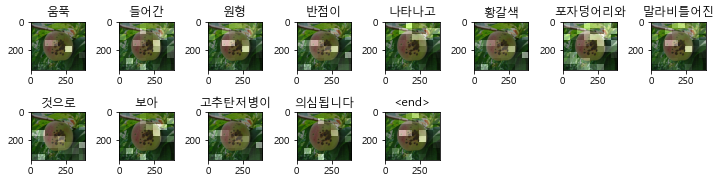

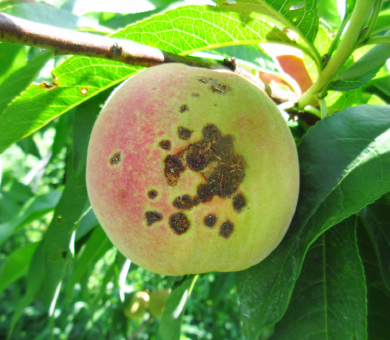

In [59]:
image_url = 'http://www.rda.go.kr/webzine/2020/08/images/sub2-4_img02.jpg'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# 개선 방향
* 데이터의 양 늘리기(새로 라벨링)
* 토크나이저를 konlpy 바꿈
* 학습데이터 바꾸기
